In [1]:
import pandas as pd 
import os, sys, sqlite3
import os.path as osp   
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../scripts")
from test_script import azi_zen_from_units

# test_folder = osp.join("..", "test_folder")


# Ids and truth

db_path  = "/groups/hep/johannbs/data/rasmus_classification_muon_3neutrino_3mio.db"
set_path =  "/groups/hep/johannbs/data/rasmus_classification_muon_1500k_sets.pkl"

test_id  = pd.read_pickle(set_path)['test']
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(f"select * from truth where event_no in {tuple(test_id)}", conn).sort_values("event_no").set_index("event_no", drop = True)
transforms = pd.read_pickle("/groups/hep/johannbs/data/transformers2.pkl")
for col in df.columns:
    if col in list(transforms['truth'].keys()):
        df[col]     = transforms["truth"][col].inverse_transform(np.array(df[col]).reshape(-1, 1)).flatten()

##### PATHS ##### 
johann = {"path":  "MuonPreds.csv",
          "color": "#712f79", 
          "name":  "AntHill"}

chriller = {"path":  "/groups/hep/chri862z/work/IceCube/predictions/Muon_ckj_2dvM_1106_final.csv",
          "color": "#20a4f3", 
          "name":  "StateFarm"}

# schauser ={"path":  "schauser_corrected4.csv", #"/groups/hep/jakobsch/predictions/jakob_predictions_1106_drunk.csv",
#           "color": "#519872", 
#           "name":  "LifeGuard"}

jonas    ={"path":  "/groups/hep/jonasv/predictions/Muon_EAngle_m27_3dj6_test_predictions.csv",
           "color": "#f7996e",
           "name":  "GGConv  "}

# retro    ={"path":  "retro_test_pred.csv",
#            "color": "k",
        #    "name":  "retro reco"}
############################
#
# schauser path: /jakobsch/predictions/jakob_predictions_0106_2.csv eller /jakobsch/predictions/jakob_predictions_0806_new.csv
# chriller path: /chri862z/work/IceCube/predictions/ckj_2dvM_0906.csv
#

Comparison = [johann, chriller, jonas]

In [2]:
def angle_diffs(A, B):
    return np.arccos(np.cos(A) * np.cos(B) + np.sin(A) * np.sin(B)) * 180 / np.pi


def cal_acc(azp, zep, azt, zet):

            s1 = np.sin( zet + azt - azp )
            s2 = np.sin( zet - azt + azp )
            c1 = np.cos( zet - zep )
            c2 = np.cos( zet + zep )
            cos_angle = 0.5*abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2)

            return np.arccos(cos_angle) * 180 / np.pi

def solid_angle(azp, zep, azt, zet):
    return np.arccos(np.sin(zet) * np.sin(zep) + np.cos(zet)*np.cos(zep)*np.cos(azt - azp)) * 180 / np.pi


for model in Comparison:
    model['df']          = pd.read_csv(model['path']).sort_values("event_no")
    model['df'].event_no = model['df'].event_no.apply(lambda x: int(x + 0.5))
    model['df']          = model['df'].set_index("event_no", drop = True)
    model['zen_diff']    = angle_diffs(model['df'].zenith_pred, df.zenith) 
    model['energy_res']  = model['df']['energy_log10_pred'] - df.energy_log10
    if "azimuth_pred" in model['df'].columns:
        model['azi_diff']    = angle_diffs(model['df'].azimuth_pred, df.azimuth)
        model['solid_angle'] = cal_acc(model['df']["azimuth_pred"], model['df']["zenith_pred"], df.azimuth, df.zenith)

In [3]:
def median_bounded_error(diffs, lims = (0, 90), bins = 100):
    count, x = np.histogram(diffs, range = lims, bins = bins)
    plt.figure()

    plt.plot((x[1:] + x[:-1])/2, count / np.sum(count) / (x[1] - x[0]))
    p50 = count[np.argmin(abs(np.cumsum(count) - np.sum(count) // 2))]/ np.sum(count) / (x[1] - x[0])
    plt.vlines(x[np.argmin(abs(np.cumsum(count) - np.sum(count) // 2))], 0, 0.2)
    return np.sqrt(0.25 / np.sum(count) / p50 ** 2)

def w_error(diffs, lims = (0, 90), bins = 100):
    count, x = np.histogram(diffs, range = lims, bins = bins)
    p25 = count[np.argmin(abs(np.cumsum(count) - np.sum(count) // 4))]/ np.sum(count) / (x[1] - x[0])
    p75 = count[np.argmin(abs(np.cumsum(count) - np.sum(count) // 4 * 3))] / np.sum(count) / (x[1] - x[0])
    return 1/1.349 * np.sqrt(0.25 * 0.75 / np.sum(count) * (1 / p25 ** 2 + 1 / p75 ** 2))

In [10]:
chriller['energy_res']

event_no
138674340    0.164727
138674343    0.066775
138674348   -0.034793
138674358         NaN
138674364         NaN
               ...   
140547624         NaN
140547629         NaN
140547636         NaN
140547642         NaN
140547646         NaN
Length: 300000, dtype: float64

AntHill:	 solid: 4.19 	 azimuth: 5.57 	 zenith 1.88 	 energy_w: 0.2761 	 ene_bias: -2.56
Errors:	 	 solid: 0.01 	 azimuth: 0.02 	 zenith 0.01 	 energy: 0.0014
StateFarm:	 solid: 4.09 	 azimuth: 5.49 	 zenith 1.72 	 energy_w: 0.1340 	 ene_bias: 0.00
Errors:	 	 solid: 0.01 	 azimuth: 0.02 	 zenith 0.01 	 energy: 0.0007
GGConv  :	 solid: 5.77 	 azimuth: 7.52 	 zenith 2.77 	 energy_w: 0.1376 	 ene_bias: 0.02
Errors:	 	 solid: 0.02 	 azimuth: 0.02 	 zenith 0.01 	 energy: 0.0006


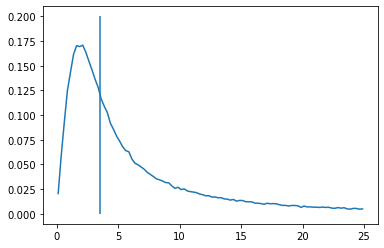

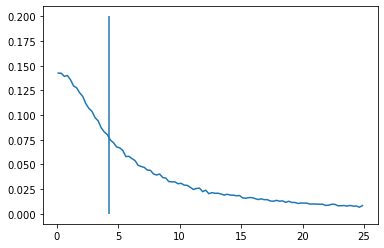

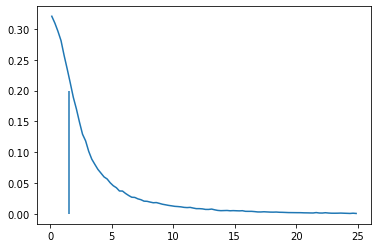

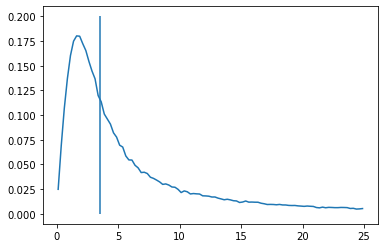

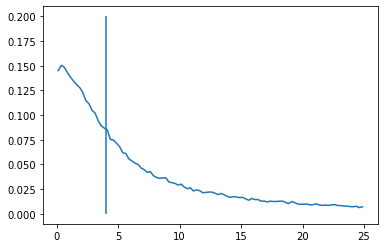

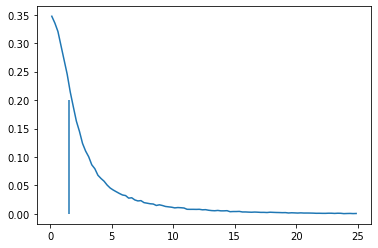

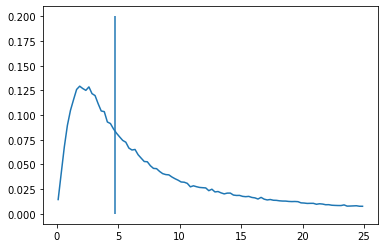

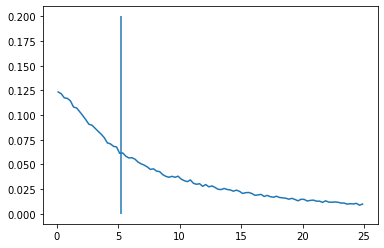

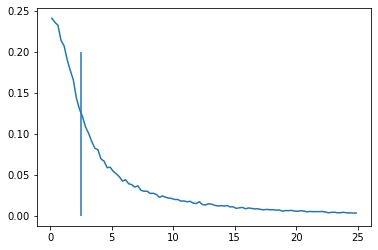

In [11]:
for model in Comparison:
    iqr = np.percentile(model['energy_res'].dropna(), [25, 50, 75])
    bias = iqr[1]
    width = (iqr[2] - iqr[0]) / 1.349
    w_err = w_error(model['energy_res'].dropna(), bins = 100, lims = (-2, 2))
    if "azi_diff" in model.keys():
        sol = np.median(model['solid_angle'].dropna())
        sol_err = median_bounded_error(model['solid_angle'], bins = 100, lims = (0, 25))
        azi = np.median(model['azi_diff'].dropna())
        azi_err = median_bounded_error(model['azi_diff'], bins = 100, lims = (0, 25))
    else:
        sol = 0.
        azi = 0.
    zen = np.median(model['zen_diff'].dropna())
    zen_err = median_bounded_error(model['zen_diff'], bins = 100, lims = (0, 25))

    print(f"{model['name']}:\t solid: {sol:.2f} \t azimuth: {azi:.2f} \t zenith {zen:.2f} \t energy_w: {width:.4f} \t ene_bias: {bias:.2f}")
    print(f"Errors:\t \t solid: {sol_err:.2f} \t azimuth: {azi_err:.2f} \t zenith {zen_err:.2f} \t energy: {w_err:.4f}")



In [105]:
for model in Comparison:
    iqr = np.percentile(model['energy_res'].dropna(), [25, 50, 75])
    bias = iqr[1]
    width = (iqr[2] - iqr[0]) / 1.349
    if "azi_diff" in model.keys():
        sol = model['solid_angle'].dropna().median()
        azi = model['azi_diff'].dropna().median()
    else:
        sol = 0.
        azi = 0.
    zen = np.median(model['zen_diff'].dropna())

    print(f"{model['name']}:\t solid: {sol:.1f} \t azimuth: {azi:.1f} \t zenith {zen:.1f} \t energy_w: {width:.2f} \t ene_bias: {bias:.2f}")

AntHill:	 solid: 4.2 	 azimuth: 5.6 	 zenith 1.9 	 energy_w: 0.28 	 ene_bias: -2.56
StateFarm:	 solid: 4.1 	 azimuth: 5.5 	 zenith 1.7 	 energy_w: 0.13 	 ene_bias: 0.00
GGConv  :	 solid: 5.8 	 azimuth: 7.5 	 zenith 2.8 	 energy_w: 0.14 	 ene_bias: 0.02


In [106]:
chriller['solid_angle']

event_no
138674340    6.860417
138674343    1.229681
138674348    1.796490
138674358         NaN
138674364         NaN
               ...   
140547624         NaN
140547629         NaN
140547636         NaN
140547642         NaN
140547646         NaN
Length: 300000, dtype: float64

In [107]:

def chosen_percentiles(diffs):
    diffs = diffs[~np.isnan(diffs)]
    u, median, low_one_sig = np.percentile(diffs, [16, 50, 68])
    return u, median, low_one_sig 

def performance(diffs, Ns):
    cuts = np.linspace(2, 4, 9)
    mask = np.searchsorted(cuts, Ns)

    us, meds, lows, ns = [], [], [], []

    for i in np.unique(mask):
        u, median, low = chosen_percentiles(diffs[mask == i]) 
        us.append(u)
        meds.append(median)
        lows.append(low)
        ns.append(np.mean(Ns[mask == i]))
    
    return_dict = {
        "us": np.array(us),
        "meds": np.array(meds),
        "lows": np.array(lows),
        "xs":  np.array(ns)
    }
    return return_dict
    
def chosen_percentiles_energy(diffs):
    diffs = diffs[~np.isnan(diffs)]
    iqr = np.percentile(diffs, [25, 50, 75])
    width = (iqr[2] - iqr[0]) / 1.349
    low, high = np.percentile(diffs, [18, 82])
    return width, (low, high)


def energy_width_and_bias(res, Ns):

    cuts = np.linspace(2, 4, 9)
    mask = np.searchsorted(cuts, Ns)

    widths, lows, highs, ns = [], [], [], []

    for i in np.unique(mask):
        w, b  = chosen_percentiles_energy(res[mask == i]) 
        widths.append(w)
        lows.append(b[0])
        highs.append(b[1])
        ns.append(np.mean(Ns[mask == i]))
    
    return_dict = {
        "xs": np.array(ns),
        "ws": np.array(widths),
        "lows": np.array(lows),
        "highs": np.array(highs)
        # "xs":  np.array(ns)
    }
    return return_dict



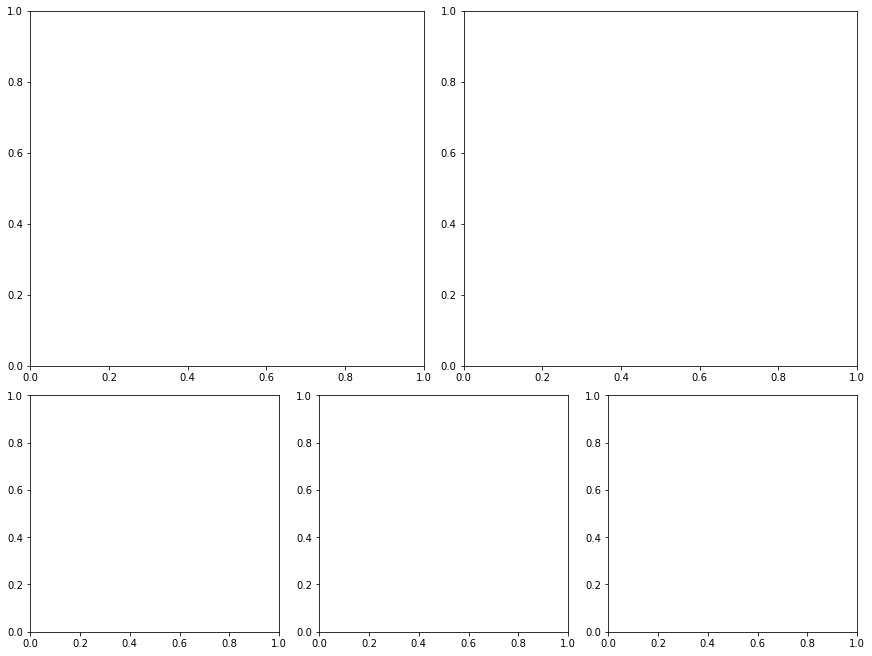

In [108]:
from matplotlib.gridspec import GridSpec
fig     = plt.figure(figsize = (12, 9), constrained_layout = True)
gs      = GridSpec(5, 6, figure = fig)


ax_zen  = fig.add_subplot(gs[:3, :3])
ax_ene  = fig.add_subplot(gs[:3, 3:])
ax_sol  = fig.add_subplot(gs[3:, :2])
ax_azi  = fig.add_subplot(gs[3:, 2:4])
ax_bl   = fig.add_subplot(gs[3:, 4:])

In [109]:
bins = np.linspace(1.5, 4, 11)

ax = ax_zen
offsets = np.linspace(-0.04, 0.04, len(Comparison))

for model, off in zip(Comparison, offsets): 
    try:
        dict = performance(model["zen_diff"], df["energy_log10"])
    except:
        dict = performance(model['zen_diff'].dropna(), df["energy_log10"])
    x, y = dict["xs"], dict["meds"]
    h, l = dict["us"], dict["lows"]
    ax.plot(x + off, y, color = model['color'], marker = "x", ls = "None")
    ax.errorbar(x + off, y, yerr = np.vstack([y - l, h - y]), color = model['color'], marker = None, s = None, label = model['name'], ls = "None")



ax.set_ylabel(r"$\Delta \theta$ [deg]")
ax.set_xlabel("$log_{10}(E)$")

ax.set_title("Zenith Angle Performance OscNext")
ax.legend(loc = "upper left")

ax2 = ax.twinx()


ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.25, color = "gray");
ax2.set_yscale("log")
ax2.set_yticks([])
ax2.set_yticklabels([])

# ax2.set_ylabel("Freq")


[]

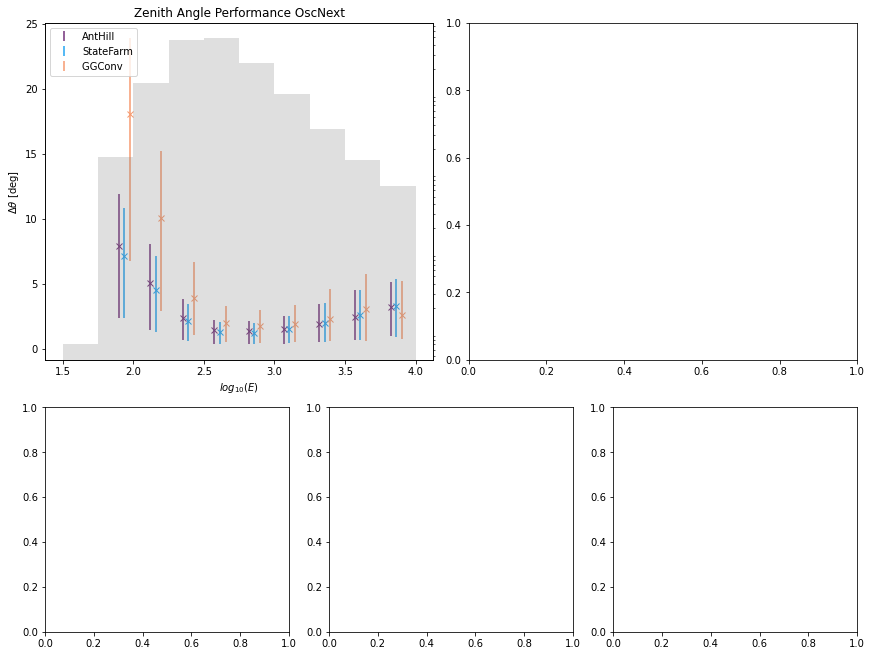

In [110]:
fig

In [111]:
ax = ax_ene
ax_bias = ax_bl

for model, off in zip(Comparison, offsets): 
    if model == johann:
        continue
    try:
        dict = energy_width_and_bias(model['energy_res'], df["energy_log10"])
    except:
        dict = energy_width_and_bias(model['energy_res'].dropna(), df["energy_log10"])

    x, w = dict["xs"], dict["ws"]
    l, h = dict["lows"], dict["highs"] 
    # h, l = dict["us"], dict["lows"]
    ax.plot(x, w, color = model['color'], marker = "o", ls = "--")
    ax_bias.plot(x, l, color = model['color'], marker = "None", ls = "--")
    ax_bias.plot(x, h, color = model['color'], marker = "None", ls = "--")
    # ax.errorbar(x, y, yerr = np.vstack([y - l, h - y]), color = model['color'], marker = None, s = None, label = model['name'], ls = "None")



# ax.set_ylabel("$\Delta \Omega$ [deg]")
ax_bias.set_ylabel("$w{\Delta E}$")
ax.set_xlabel("$log_{10}(E)$")

ax.set_title("Energy Performance OscNext")

ax_bias.set_title("Energy Bias")
ax_bias.set_xlabel("median($\log_{10}(E_{reco}/E_{truth})$)")


ax2 = ax.twinx()
ax2.set_yscale("log")

ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.25, color = "gray");
ax2.set_ylabel("Freq of Test Data")


ax2 = ax_bl.twinx()
ax2.set_yscale("log")

ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.25, color = "gray");
ax2.set_ylabel("Freq of Test Data")

# ax2 = ax.twinx()
# ax2.set_yscale("log")

# ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.25, color = "gray");
# ax2.set_ylabel("Freq")


# ax2 = ax_bl.twinx()
# ax2.set_yscale("log")

# ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.25, color = "gray");
# ax2.set_ylabel("Freq")


Text(0, 0.5, 'Freq of Test Data')

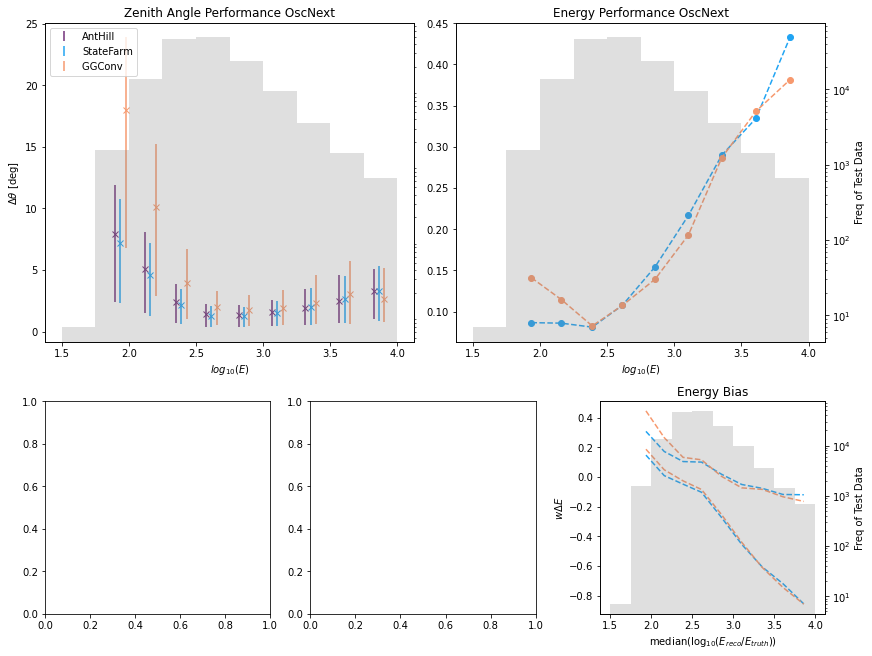

In [112]:
fig

In [113]:
ax = ax_azi
offsets *= 1.1

for model, off in zip(Comparison, offsets): 
    if "azi_diff" in model.keys():
        try:
            dict = performance(abs(model['azi_diff']), df["energy_log10"])
        except:
            dict = performance(abs(model['azi_diff'].dropna()), df["energy_log10"])
    x, y = dict["xs"], dict["meds"]
    h, l = dict["us"], dict["lows"]
    ax.scatter(x + off, y, color = model['color'], s = 10,  marker = "x", ls = "None")
    ax.errorbar(x + off, y, yerr = np.vstack([y - l, h - y]), color = model['color'], marker = None, s = None, label = model['name'], ls = "None", elinewidth = 1)



ax.set_ylabel("$\Delta \phi$ [deg]")
ax.set_xlabel("$log_{10}(E)$")

ax.set_title("Azimuth")

ax2 = ax.twinx()
ax2.set_yscale("log")

ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.2, color = "gray");
# ax2.set_ylabel("Freq")
ax2.set_yticklabels([])

[Text(1, 0.1, ''),
 Text(1, 1.0, ''),
 Text(1, 10.0, ''),
 Text(1, 100.0, ''),
 Text(1, 1000.0, ''),
 Text(1, 10000.0, ''),
 Text(1, 100000.0, ''),
 Text(1, 1000000.0, '')]

In [114]:
ax = ax_sol

for model, off in zip(Comparison, offsets): 
    if "azi_diff" in model.keys():
        try:
            dict = performance(abs(model['solid_angle']), df["energy_log10"])
        except:
            dict = performance(abs(model['solid_angle'].dropna()), df["energy_log10"])
    # dict = performance(model['solid_angle'], df["energy_log10"])
    x, y = dict["xs"], dict["meds"]
    h, l = dict["us"], dict["lows"]
    ax.scatter(x + off, y, color = model['color'], marker = "x", ls = "None", s= 10)
    ax.errorbar(x + off, y, yerr = np.vstack([y - l, h - y]), color = model['color'], marker = None, s = None, label = model['name'], ls = "None", elinewidth = 1)



ax.set_ylabel("$\Delta \Omega$ [deg]")
ax.set_xlabel("$log_{10}(E)$")

ax.set_title("Angle")

# ax2 = ax.twinx()
# ax2.set_yscale("log")

# ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.2, color = "gray");
# # ax2.set_ylabel("Freq")
# ax2.set_yticklabels([])


# ax.set_ylabel("$\Delta \Omega$ [deg]")
# ax.set_xlabel("$log_{10}(E)$")

ax.set_title("Angle")

ax2 = ax.twinx()
ax2.set_yscale("log")

ax2.hist(df['energy_log10'], bins = bins, zorder = 5, alpha = 0.2, color = "gray");
# ax2.set_ylabel("Freq")

ax2.set_yticklabels([])


[Text(1, 0.1, ''),
 Text(1, 1.0, ''),
 Text(1, 10.0, ''),
 Text(1, 100.0, ''),
 Text(1, 1000.0, ''),
 Text(1, 10000.0, ''),
 Text(1, 100000.0, ''),
 Text(1, 1000000.0, '')]

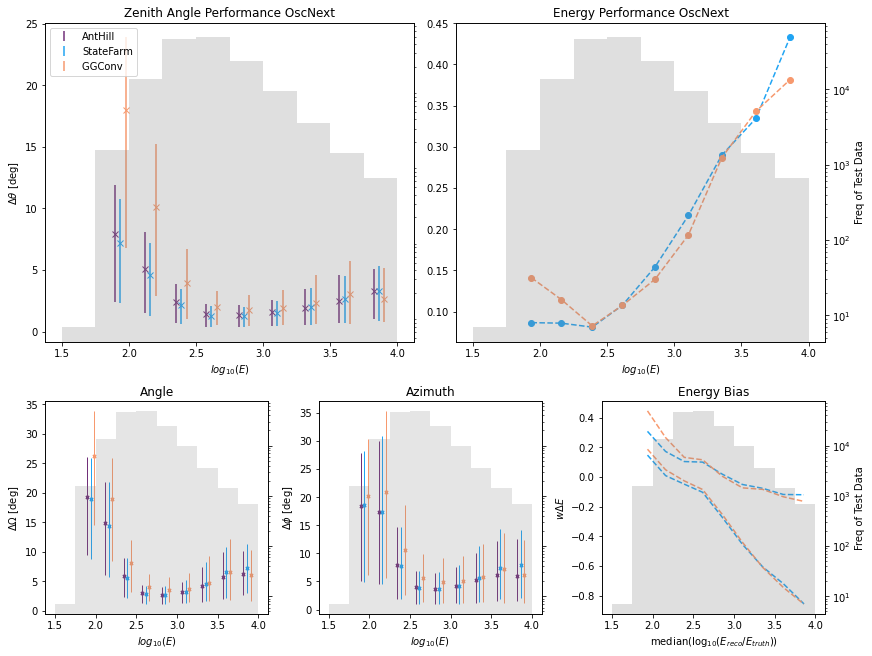

In [115]:
fig

In [116]:
fig.savefig("../figures/MuonPerformance.pdf")